# Time Series Analysis: Tutorial 1

We have two options to model the long term component of a time series:
    
    1. Parametric (global) approach
    2. Flexible (local) approach
    
In this tutorial we follow the first approach and model the long term trend as a parametric function over time. We estimate this trend by fitting a trend model to the data. We assume on of the following "patterns" for the trend: 

- Linear Trend: $L_{t} = c_{0} + c_{1}t$
- Quadratic Trend: $ L_{t} = c_{0}+c_{1}t+c_{2}t^2$
- Cubic Trend: $L_{t} = c_{0}+c_{1}t+c_{2}t^2+c_{3}t^3$
- Exponential Trend: $L_{t}=A\cdot e^{rt}$

Note that if models are (or can be made) linear in the parameters we can use ordinary least squares (OLS). By transforming our model we may therefore be able to estimate the trend by OLS even if the trend function is non-linear in $t$.

## Import packages

In [59]:
import numpy as np               # for basic operations
import matplotlib.pyplot as plt  # for plots 
plt.style.use('ggplot')
plt.rc('text', usetex=True)
import pandas as pd              # for data manipulation
import statsmodels.api as sm     # for statistical models

## Data

In [70]:
# Load the Stata-file into a dataframe. It is a data file with US population values from 1790 to 1990 in 10-year steps.
series=pd.read_stata('C:/Users/MS/Documents/TU/Teaching/TSA/01-Tutorial-1-Introduction/Programming/USpop.dta')
series=series.drop([21,22]) # we drop these two observations because they are NA. 

# Calculate the time series of relative changes between each observation (each decade) for the series.
series_relativechange=100*series.pct_change()

# we also create a time variable, data frame
time = pd.date_range(start="1790", end="2000", inclusive=None, freq="10Y")
data = pd.DataFrame(time, columns=['date'])
ts=data.assign(pop=series.values,pop_relative=series_relativechange.values)

# Inspect the data
ts

,date,pop,pop_relative
0,1790-12-31,3.929214,NaN
1,1800-12-31,5.308483,35.102924
2,1810-12-31,7.239881,36.383238
3,1820-12-31,9.638453,33.129992
4,1830-12-31,12.860702,33.431184
5,1840-12-31,17.063353,32.678239
6,1850-12-31,23.191876,35.916288
7,1860-12-31,31.443321,35.579032
8,1870-12-31,38.558371,22.628176
9,1880-12-31,50.189209,30.164236


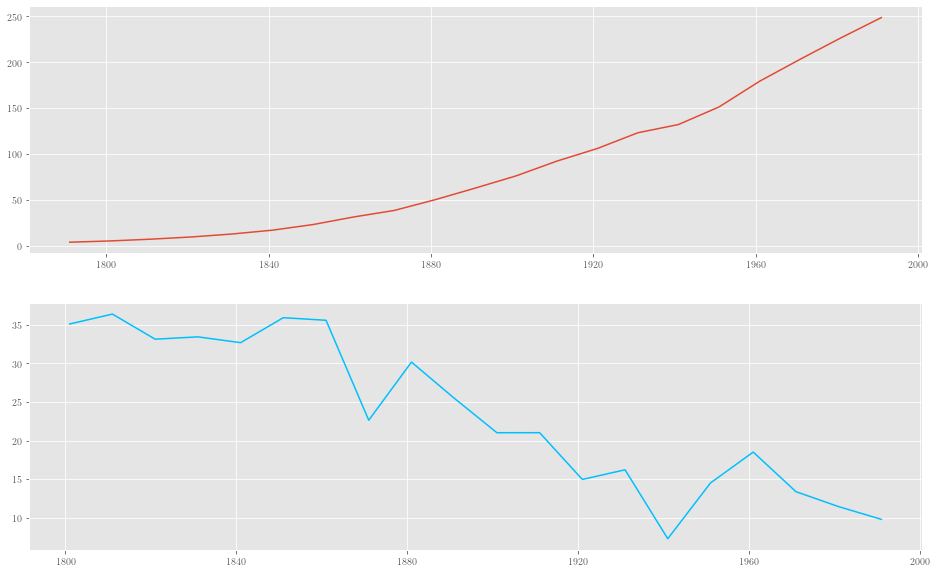

In [72]:
# Plot both series with matplotlib.
fig, ax=plt.subplots(2,1,figsize=(16,10))
ax[0].plot(ts['date'],ts['pop'])
ax[1].plot(ts['date'],ts['pop_relative'],c="deepskyblue")

## Simple deterministic trend models

We try to answer the question: Which (of the above) deterministic trend models seems appropiate to model the long-term pattern of the time seris?

Steps: 
1. Assume a deterministic trend model
2. estimate the model, plot the fitted values against the actual data
3. Inspect the residuals: do they look "random"? 

### Linear trend model

In [75]:
# Estimate the linear trend. You can use the linear regression command 'sm.OLS(dep,indep)' from statsmodels.
y=ts['pop']

# You can either just regress on the periods t_1, t_2, t_3, ... or you regress on the actual years 
# 1790, 1800, 1810, ...
t_periods=[i for i in range(1,22)]
t_years=[1790+i*10 for i in range(21)]
X=sm.add_constant(t_years)
model = sm.OLS(y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     224.3
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           5.65e-12
Time:                        12:25:15   Log-Likelihood:                -94.147
No. Observations:                  21   AIC:                             192.3
Df Residuals:                      19   BIC:                             194.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2211.3376    153.450    -14.411      0.0

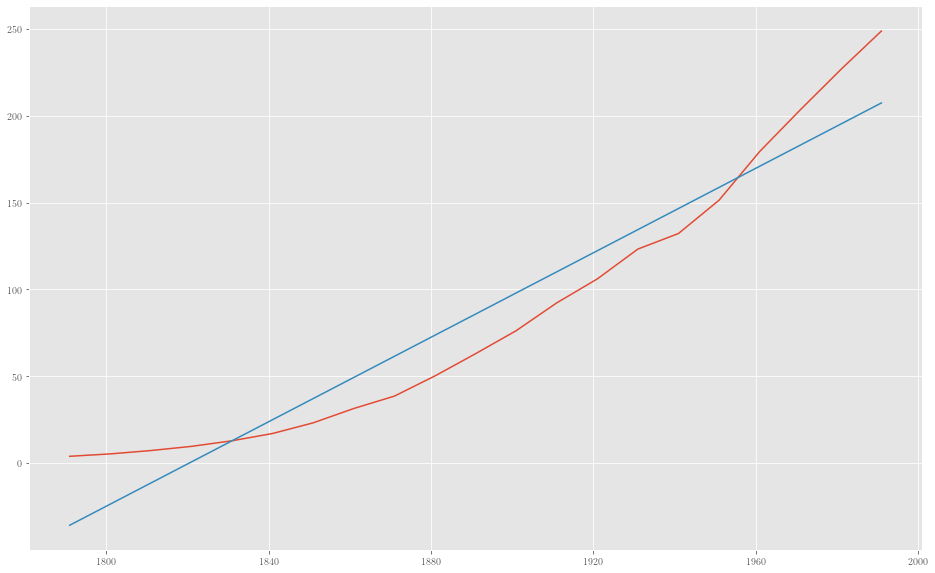

In [76]:
# Use the estimated model to predict the US population. Plot the prediction into the original plot. Does the model
# seem appropriate?
prediction=result.predict(X)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(ts['date'],ts['pop'])
plt.plot(ts['date'],prediction)

Recall: 

In our regression we estimate: $min_{\alpha,\beta} \sum_{t=1}^T (y_t-\alpha-\beta t)^2$

We obtain fitted values (our trend estimate) from this regression (the blue line!): $T_t=\hat{y}_t=\hat{\alpha}+\hat{\beta}t$

Which we can use to calculate the residuals: $\hat{\epsilon}_t=y_t-T_t$


How should the residuals "behave" if our trend model would be appropriate? (if we assume there was no seasonality/cycle!)

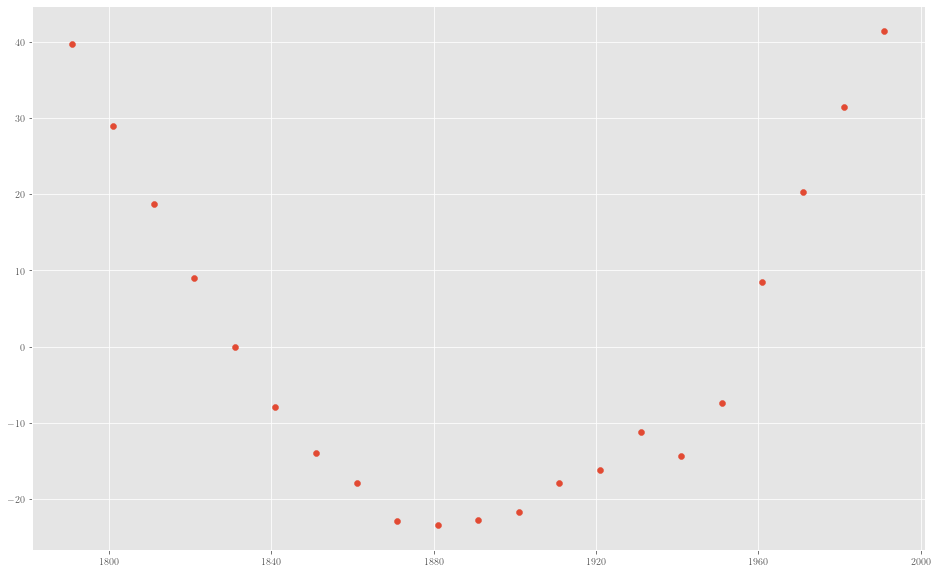

In [79]:
# Check the residuals to further adress the question of appropriateness of the linear trend model. What should they
# behave like? What can you conclude?
fig, ax=plt.subplots(figsize=(16,10))
plt.scatter(ts['date'],result.resid)

### Linear trend model with log-data

Note that we can transform the trend model $L_{t}=A\cdot e^{rt}$, using a log transformation, to: $log L_{t}=logA + r\cdot t$

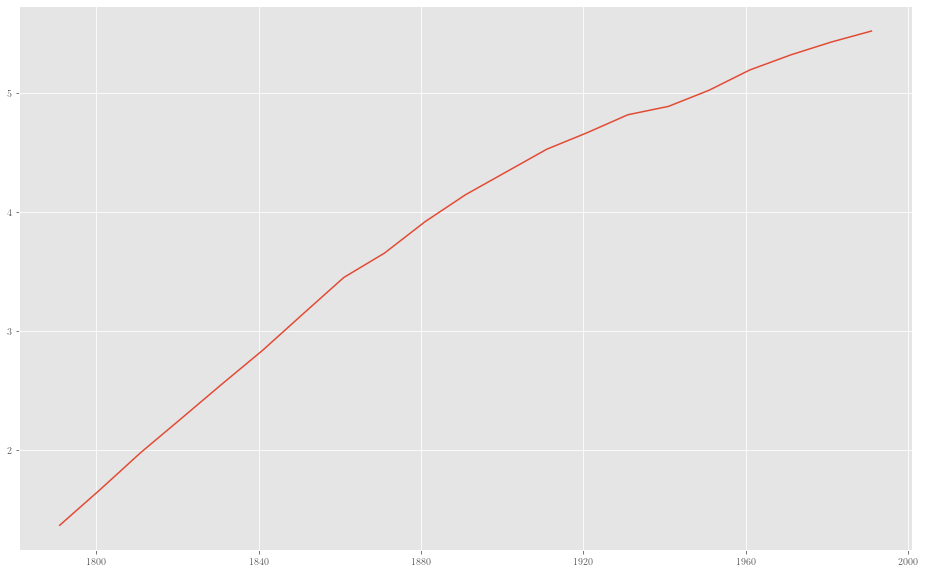

In [80]:
# Reproduce the linear trend model for log-data.
ts['log_pop'] = np.log(ts['pop'])
fig, ax=plt.subplots(figsize=(16,10))
# plt.plot(ts['date'],ts['pop'])
plt.plot(ts['date'],ts['log_pop'])

In [81]:
# Estimate the model via OLS.
y_log=ts['log_pop']
X=sm.add_constant(t_years)
model_log = sm.OLS(y_log,X)
result_log = model_log.fit()
print(result_log.summary())

                            OLS Regression Results                            
Dep. Variable:                log_pop   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     570.4
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           1.24e-15
Time:                        12:37:40   Log-Likelihood:                 1.1079
No. Observations:                  21   AIC:                             1.784
Df Residuals:                      19   BIC:                             3.873
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.4125      1.644    -21.534      0.0

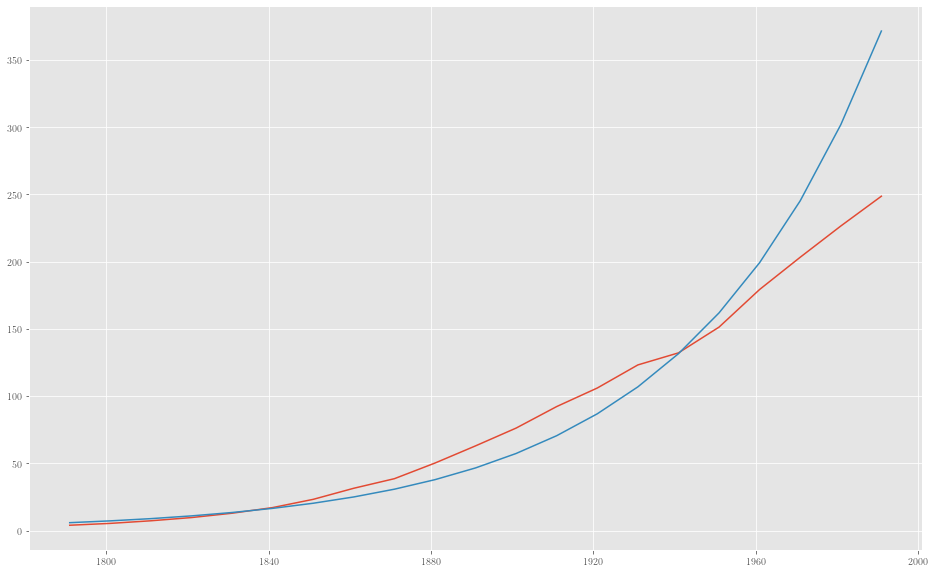

In [82]:
# Plot the prediction against the observed data. Note that the model makes log-predictions, i.e. you should
# compute the exponentials of the predictions in order to make a comparison to the original population data.
prediction_log=np.exp(result_log.predict(X))
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(ts['date'],ts['pop'])
plt.plot(ts['date'],prediction_log)

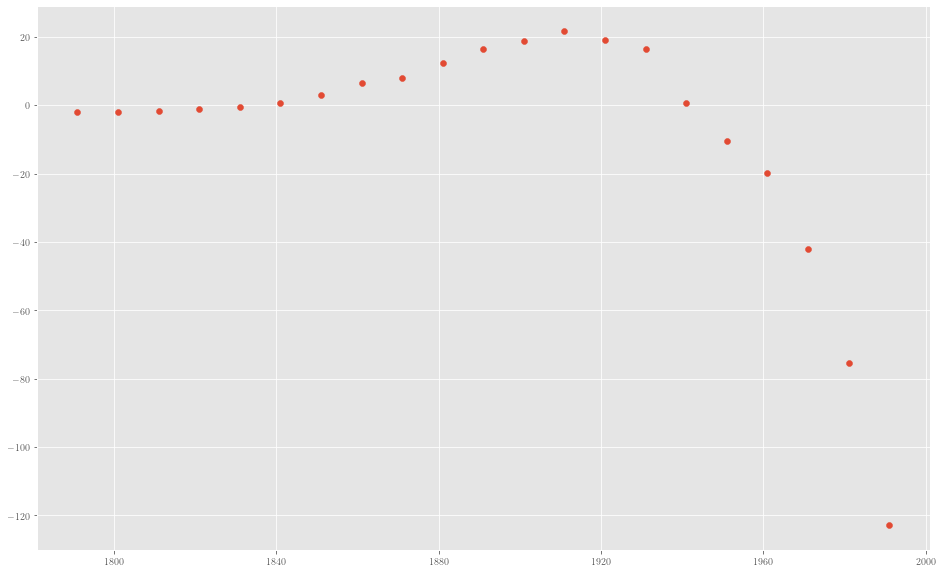

In [83]:
# Check the residuals for the log. Now again you have to compute the residuals of the above graph, i.e. you cannot
# use the residuals of the log-model.
# What do you conclude? Do the residuals behave appropriately?
residuals=ts['pop']-prediction_log
fig, ax=plt.subplots(figsize=(16,10))
plt.scatter(ts['date'],residuals)

In [84]:
# The plot of the residuals of the log-model suggests, that splitting the data into 2 sequences could
# be sensible (that is the same idea as estimating a Spline function, but we do not 
# pin the estimated value at the same value, when the trend changes). 
# Split the series into 2 appropriate periods and fit linear log-models for each. 
# I chose the periods 1790-1910 and 1910-1990.
y_log_part1=y_log[:13]
y_log_part2=y_log[12:]
X1=sm.add_constant(t_years[:13])
X2=sm.add_constant(t_years[12:])

#Estimate model for the time until 1920
model_log_part1 = sm.OLS(y_log_part1,X1)
result_log_part1 = model_log_part1.fit()

#Estimate model for the time after 1920
model_log_part2 = sm.OLS(y_log_part2,X2)
result_log_part2 = model_log_part2.fit()

print(result_log_part1.summary())
print(result_log_part2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_pop   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2207.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           4.98e-14
Time:                        12:38:53   Log-Likelihood:                 16.008
No. Observations:                  13   AIC:                            -28.02
Df Residuals:                      11   BIC:                            -26.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -46.4042      1.053    -44.062      0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


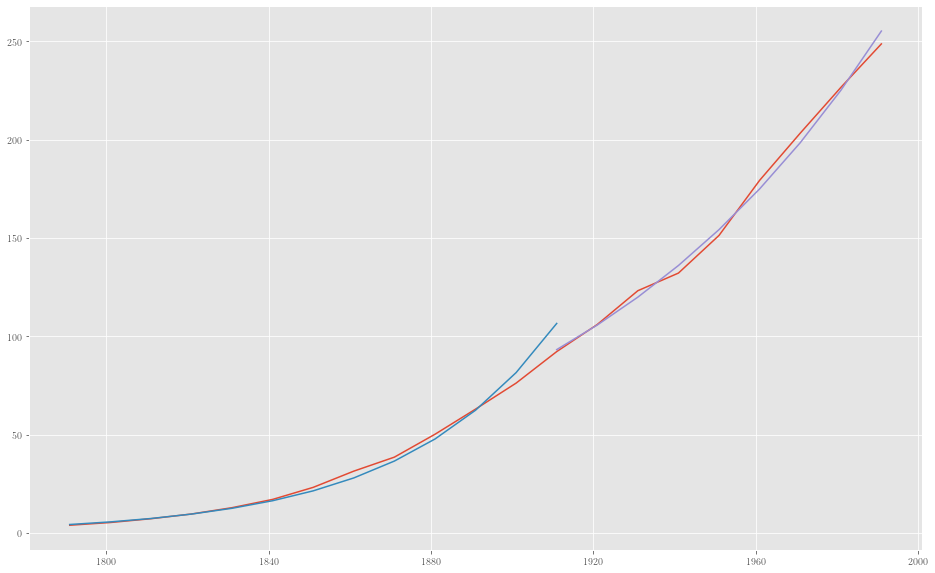

In [51]:
# Plot the predictions against the observed data.
prediction_log_part1=np.exp(result_log_part1.predict(X1))
prediction_log_part2=np.exp(result_log_part2.predict(X2))
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(ts['date'],ts['pop'])
plt.plot(ts['date'].values[:13],prediction_log_part1)
plt.plot(ts['date'].values[12:],prediction_log_part2)

$\textbf{ADDITIONAL EXERCISE:}$ Seperate at time t=1920 and t=1900 or other seemingly appropriate points in time and rerun the procedure. Check the residuals to decide which separation works best.

This is not a spline regression, what would a spline regression do? 

### Quadratic trend model

In [85]:
# Fit a quadratic trend model to the data. 

# Generate the data matrix.
t_years=[1790+i*10 for i in range(21)]
t_years_2=[(1790+i*10)**2 for i in range(21)]
X=np.array([t_years,t_years_2])
X=X.transpose()

# Fit the model.
X_2=sm.add_constant(X)
model_2 = sm.OLS(ts['pop'],X_2)
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     8050.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           2.70e-27
Time:                        12:40:13   Log-Likelihood:                -49.550
No. Observations:                  21   AIC:                             105.1
Df Residuals:                      18   BIC:                             108.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.101e+04    659.433     31.855      0.0

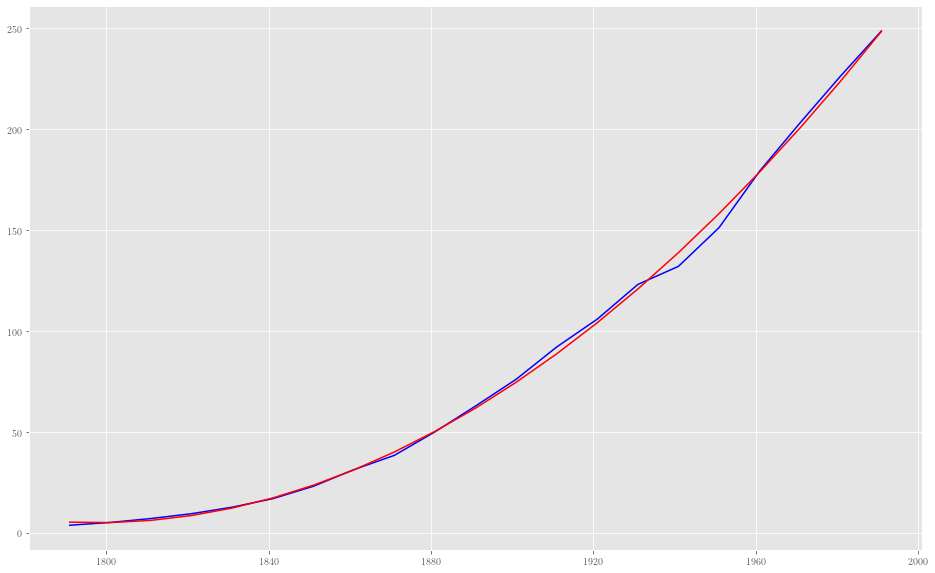

In [53]:
#Plot the prediction against the observed data.
prediction_2=result_2.predict(X_2)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(ts['date'],ts['pop'],c='blue')
plt.plot(ts['date'],prediction_2,c='red')

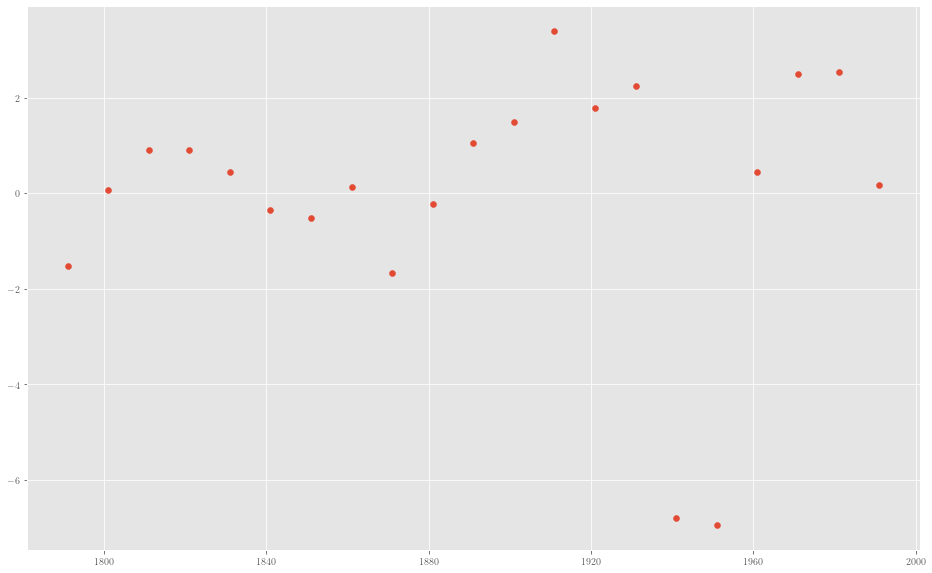

In [86]:
#Check the residuals. What is your conclusion?
fig, ax=plt.subplots(figsize=(16,10))
plt.scatter(ts['date'],result_2.resid)

## Cubic trend model

In [87]:
# Fit a quadratic trend model to the data. You can recycle all the code above.

# Generate the data matrix.
t_years=[1790+i*10 for i in range(21)]
t_years_2=[(1790+i*10)**2 for i in range(21)]
t_years_3=[(1790+i*10)**3 for i in range(21)]
X=np.array([t_years,t_years_2,t_years_3])
X=X.transpose()

# Fit the model.
X_3=sm.add_constant(X)
model_3 = sm.OLS(ts['pop'],X_3)
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5320.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           1.84e-25
Time:                        12:40:33   Log-Likelihood:                -49.042
No. Observations:                  21   AIC:                             106.1
Df Residuals:                      17   BIC:                             110.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -770.0663   2.37e+04     -0.032      0.9

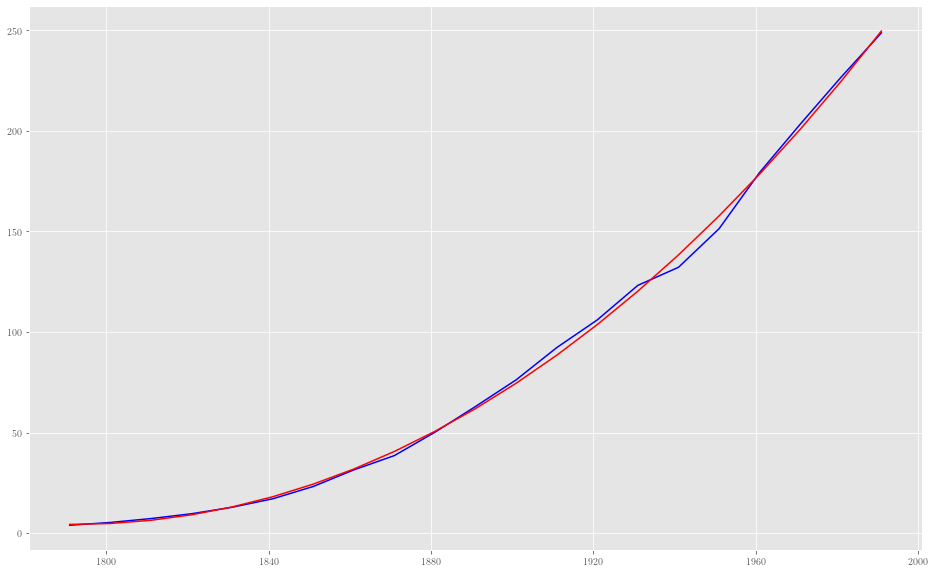

In [43]:
# Plot the prediction against the observed data.
prediction_3=result_3.predict(X_3)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(ts['date'],ts['pop'],c='blue')
plt.plot(ts['date'],prediction_3,c='red')

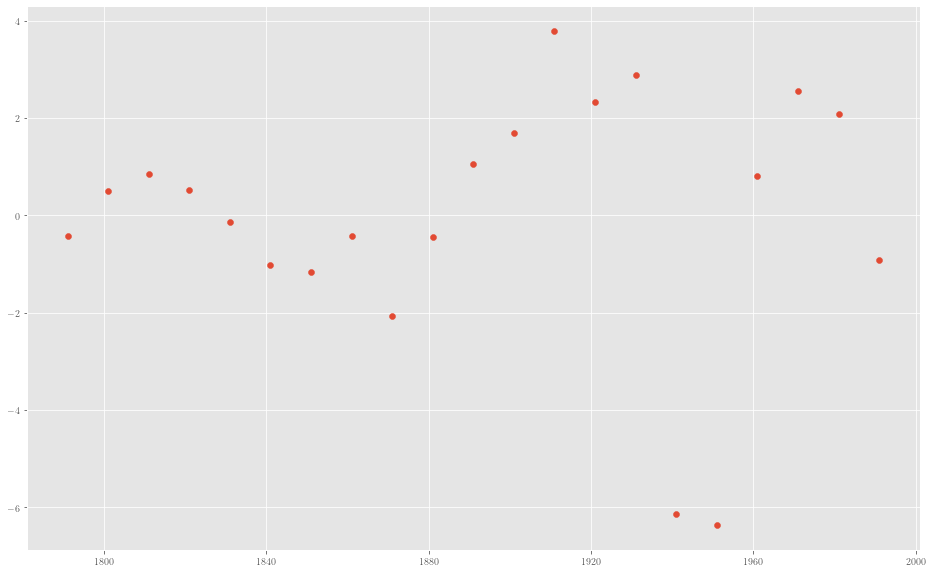

In [88]:
# Check the residuals. What is your conclusion?
fig, ax=plt.subplots(figsize=(16,10))
plt.scatter(ts['date'],result_3.resid)

## Model comparison and forecast

In [57]:
# Compare the models you have fitted to the dataset. Which of these models fits best to the series?

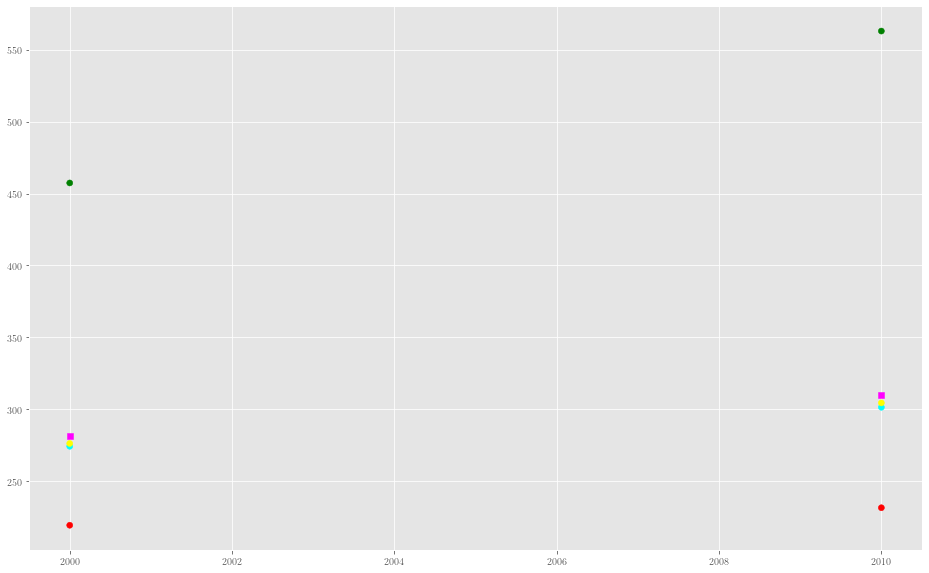

In [90]:
# Calculate forecasts for the year 2000 and 2010 and compare them with the true US popolution
# in 2000 (281.55 Mio.) and 2010 (310.3 Mio.).

# Linear trend
prediction_linear_2000=result.predict([1,2000])
prediction_linear_2010=result.predict([1,2010])

# Linear trend with log-data
prediction_log_2000=np.exp(result_log.predict([1,2000]))
prediction_log_2010=np.exp(result_log.predict([1,2010]))

# Quadratic trend
prediction_2_2000=result_2.predict([1,2000,2000**2])
prediction_2_2010=result_2.predict([1,2010,2010**2])

# Cubic trend
prediction_3_2000=result_3.predict([1,2000,2000**2,2000**3])
prediction_3_2010=result_3.predict([1,2010,2010**2,2010**3])

# Plot the predictions
forecasts=[prediction_linear_2000,prediction_log_2000,prediction_2_2000,prediction_3_2000,prediction_linear_2010,prediction_log_2010,prediction_2_2010,prediction_3_2010]
forecasts
fig, ax=plt.subplots(figsize=(16,10))
plt.scatter([2000,2000,2000,2000,2010,2010,2010,2010],
            forecasts,c=['red','green','cyan','yellow','red','green','cyan','yellow'])
plt.scatter([2000,2010],[281.55,310.3],c=['magenta','magenta'],marker='s')

# linear model = red
# log model = green
# squared trend = cyan
# cubic trend = yellow
# true value = magenta